In [1]:
import pandas as pd
from sklearn.ensemble import StackingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Load the dataset
data = pd.read_csv("C:/Maize_Chainat_C/45Datapoint_Master/5VI_RawData_30Mar_Multiparameter_V8_CV_ALL.csv")

# Data Preprocessing
columns_to_drop = ['id', 'Plot_Name']
data = data.drop(columns=columns_to_drop)
data = data.dropna()  # Handle missing values

X = data[['Cire_CV','P','K', 'SoilHumi','Wind speed','Temperature','Evapotranspiration']]
y = data['Seed']

# Split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Stacking
base_models = [
    ("CatBoost", CatBoostRegressor(verbose=0, random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42))
]

stacked_model = StackingRegressor(estimators=base_models, final_estimator=RidgeCV())
stacked_model.fit(X_train, y_train)
stacked_predictions = stacked_model.predict(X_test)

# Bagging
base_model = DecisionTreeRegressor(random_state=42)
bagging_model = BaggingRegressor(base_model, n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)
bagging_predictions = bagging_model.predict(X_test)

# Save the predictions to CSV
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Stacked_Predictions": stacked_predictions,
    "Bagging_Predictions": bagging_predictions
})

predictions_df.to_csv("C:/Maize_Chainat_C/45Datapoint_Master/ML_analysis/4Oct_Predict_With_ensemble/ensemble_predictions_stacking_bagging.csv", index=True)


  Metric  Stacking   Bagging
0    MAE  1.566386  1.541556
1    MSE  3.684862  4.081031
2   RMSE  1.919599  2.020156
3     R2  0.640003  0.601298


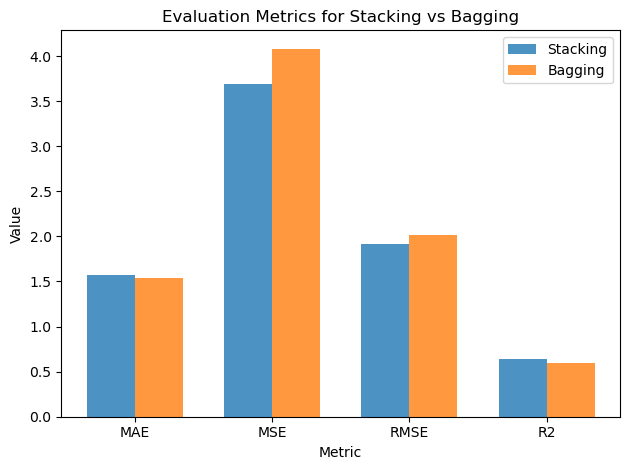

In [3]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Load the predictions CSV
data = pd.read_csv("C:/Maize_Chainat_C/45Datapoint_Master/ML_analysis/4Oct_Predict_With_ensemble/ensemble_predictions_stacking_bagging.csv")

# Extract actual and predicted values
actual_values = data['Actual']
stacked_predictions = data['Stacked_Predictions']
bagging_predictions = data['Bagging_Predictions']

# Evaluate Metrics
metrics = {
    "MAE": (mean_absolute_error, {}),
    "MSE": (mean_squared_error, {}),
    "RMSE": (lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), {}),
    "R2": (r2_score, {})
}

results = {"Metric": [], "Stacking": [], "Bagging": []}

for metric_name, (metric_func, extra_args) in metrics.items():
    results["Metric"].append(metric_name)
    results["Stacking"].append(metric_func(actual_values, stacked_predictions, **extra_args))
    results["Bagging"].append(metric_func(actual_values, bagging_predictions, **extra_args))

results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("C:/Maize_Chainat_C/45Datapoint_Master/ML_analysis/4Oct_Predict_With_ensemble/ensemble_predictions_stacking_bagging_performance.csv", index=True)

# Visualization
bar_width = 0.35
index = np.arange(len(metrics))

fig, ax = plt.subplots()
bar1 = ax.bar(index, results_df['Stacking'], bar_width, label='Stacking', alpha=0.8)
bar2 = ax.bar(index + bar_width, results_df['Bagging'], bar_width, label='Bagging', alpha=0.8)

ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Evaluation Metrics for Stacking vs Bagging')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(results_df['Metric'])
ax.legend()

plt.tight_layout()
plt.show()
